In [1]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer 
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords
from scipy.sparse import hstack,csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from scipy.sparse import hstack,csr_matrix
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import tensorflow as tf
import tensorflow as tf; print(tf.__version__)
from spacy.lang.en import English

# import tensorflow as tf
import datetime

# import pandas as pd
from spacy.lang.en import English
import spacy
import re
# import matplotlib.pyplot as plt
# import seaborn as sns
sns.set()

2.5.0


In [42]:
df = pd.read_csv('/content/drive/MyDrive/fake_job_postings 2.csv')

In [43]:
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [45]:
df["fraudulent"].value_counts()


0    17014
1      866
Name: fraudulent, dtype: int64

In [46]:
split_location=df["location"].apply(lambda x:str(x).strip().split(','))
split_location=split_location.apply(pd.Series)

In [47]:
split_location

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,US,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NZ,,Auckland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,IA,Wever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,DC,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,FL,Fort Worth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,CA,ON,Toronto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17876,US,PA,Philadelphia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17877,US,TX,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17878,NG,LA,Lagos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
split_location[~(split_location[4].isnull())]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
733,US,AL,Birmingham,Montgomery,Atlanta Ga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1725,US,TX,Austin,San Antonio,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4396,US,MI,Hartford,Paw Paw,Lawton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480,US,CA,San Jose,SFO,Austin,OH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4527,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4650,US,FL,Central Fl,Nort Fl,Georgia,Alabama,Tennessee,South Carolina,North Carolina,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11987,US,CA,Los Angeles,Anaheim,San Diego,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12383,NL,ZH,Rotterdam,The Hague,Utrecht,Amsterdam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12467,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13181,US,CA,Los Angeles,California,San Francisco,California,San Jose,California,Manhattan,New York,Las Vegas,Nevada,Phoenix,Arizona,San Diego,California


In [49]:
df['country']=split_location[0]
df['location_count']=df["location"].apply(lambda x:str(x).split(', '))
df['location_count']=df['location_count'].apply(lambda x:max(len(x)-2,0))

In [50]:
df['null_count']=df.isnull().sum(axis=1)

In [51]:
country_code_mapping = {"BD": "BGD", "BE": "BEL", "BF": "BFA", "BG": "BGR", "BA": "BIH", "BB": "BRB", "WF": "WLF", "BL": "BLM", "BM": "BMU", "BN": "BRN", "BO": "BOL", "BH": "BHR", "BI": "BDI", "BJ": "BEN", "BT": "BTN", "JM": "JAM", "BV": "BVT", "BW": "BWA", "WS": "WSM", "BQ": "BES", "BR": "BRA", "BS": "BHS", "JE": "JEY", "BY": "BLR", "BZ": "BLZ", "RU": "RUS", "RW": "RWA", "RS": "SRB", "TL": "TLS", "RE": "REU", "TM": "TKM", "TJ": "TJK", "RO": "ROU", "TK": "TKL", "GW": "GNB", "GU": "GUM", "GT": "GTM", "GS": "SGS", "GR": "GRC", "GQ": "GNQ", "GP": "GLP", "JP": "JPN", "GY": "GUY", "GG": "GGY", "GF": "GUF", "GE": "GEO", "GD": "GRD", "GB": "GBR", "GA": "GAB", "SV": "SLV", "GN": "GIN", "GM": "GMB", "GL": "GRL", "GI": "GIB", "GH": "GHA", "OM": "OMN", "TN": "TUN", "JO": "JOR", "HR": "HRV", "HT": "HTI", "HU": "HUN", "HK": "HKG", "HN": "HND", "HM": "HMD", "VE": "VEN", "PR": "PRI", "PS": "PSE", "PW": "PLW", "PT": "PRT", "SJ": "SJM", "PY": "PRY", "IQ": "IRQ", "PA": "PAN", "PF": "PYF", "PG": "PNG", "PE": "PER", "PK": "PAK", "PH": "PHL", "PN": "PCN", "PL": "POL", "PM": "SPM", "ZM": "ZMB", "EH": "ESH", "EE": "EST", "EG": "EGY", "ZA": "ZAF", "EC": "ECU", "IT": "ITA", "VN": "VNM", "SB": "SLB", "ET": "ETH", "SO": "SOM", "ZW": "ZWE", "SA": "SAU", "ES": "ESP", "ER": "ERI", "ME": "MNE", "MD": "MDA", "MG": "MDG", "MF": "MAF", "MA": "MAR", "MC": "MCO", "UZ": "UZB", "MM": "MMR", "ML": "MLI", "MO": "MAC", "MN": "MNG", "MH": "MHL", "MK": "MKD", "MU": "MUS", "MT": "MLT", "MW": "MWI", "MV": "MDV", "MQ": "MTQ", "MP": "MNP", "MS": "MSR", "MR": "MRT", "IM": "IMN", "UG": "UGA", "TZ": "TZA", "MY": "MYS", "MX": "MEX", "IL": "ISR", "FR": "FRA", "IO": "IOT", "SH": "SHN", "FI": "FIN", "FJ": "FJI", "FK": "FLK", "FM": "FSM", "FO": "FRO", "NI": "NIC", "NL": "NLD", "NO": "NOR", "NA": "NAM", "VU": "VUT", "NC": "NCL", "NE": "NER", "NF": "NFK", "NG": "NGA", "NZ": "NZL", "NP": "NPL", "NR": "NRU", "NU": "NIU", "CK": "COK", "XK": "XKX", "CI": "CIV", "CH": "CHE", "CO": "COL", "CN": "CHN", "CM": "CMR", "CL": "CHL", "CC": "CCK", "CA": "CAN", "CG": "COG", "CF": "CAF", "CD": "COD", "CZ": "CZE", "CY": "CYP", "CX": "CXR", "CR": "CRI", "CW": "CUW", "CV": "CPV", "CU": "CUB", "SZ": "SWZ", "SY": "SYR", "SX": "SXM", "KG": "KGZ", "KE": "KEN", "SS": "SSD", "SR": "SUR", "KI": "KIR", "KH": "KHM", "KN": "KNA", "KM": "COM", "ST": "STP", "SK": "SVK", "KR": "KOR", "SI": "SVN", "KP": "PRK", "KW": "KWT", "SN": "SEN", "SM": "SMR", "SL": "SLE", "SC": "SYC", "KZ": "KAZ", "KY": "CYM", "SG": "SGP", "SE": "SWE", "SD": "SDN", "DO": "DOM", "DM": "DMA", "DJ": "DJI", "DK": "DNK", "VG": "VGB", "DE": "DEU", "YE": "YEM", "DZ": "DZA", "US": "USA", "UY": "URY", "YT": "MYT", "UM": "UMI", "LB": "LBN", "LC": "LCA", "LA": "LAO", "TV": "TUV", "TW": "TWN", "TT": "TTO", "TR": "TUR", "LK": "LKA", "LI": "LIE", "LV": "LVA", "TO": "TON", "LT": "LTU", "LU": "LUX", "LR": "LBR", "LS": "LSO", "TH": "THA", "TF": "ATF", "TG": "TGO", "TD": "TCD", "TC": "TCA", "LY": "LBY", "VA": "VAT", "VC": "VCT", "AE": "ARE", "AD": "AND", "AG": "ATG", "AF": "AFG", "AI": "AIA", "VI": "VIR", "IS": "ISL", "IR": "IRN", "AM": "ARM", "AL": "ALB", "AO": "AGO", "AQ": "ATA", "AS": "ASM", "AR": "ARG", "AU": "AUS", "AT": "AUT", "AW": "ABW", "IN": "IND", "AX": "ALA", "AZ": "AZE", "IE": "IRL", "ID": "IDN", "UA": "UKR", "QA": "QAT", "MZ": "MOZ"}

In [52]:
df['country']=df['country'].apply(lambda x:country_code_mapping[x] if x!='nan' else 'nan')

In [53]:
df['country'][:10]

0    USA
1    NZL
2    USA
3    USA
4    USA
5    USA
6    DEU
7    USA
8    USA
9    USA
Name: country, dtype: object

In [54]:
loc = df['country'].copy()
len(loc)

17880

In [55]:
loc_list =[]
loc.replace(np.NaN,'0',inplace=True)
for i in range(len(loc)):
    if loc[i]!=np.nan:
        country_ls = re.findall('\w[A-Z]*',loc[i])
        loc_list.append(country_ls[0])
loc_list = pd.Series(loc_list)

[]

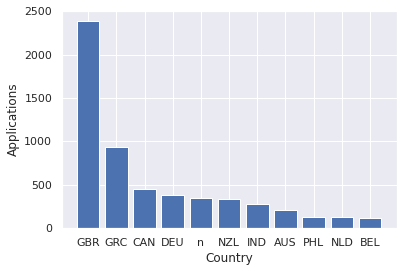

In [17]:
# there are lot of countries with 1 or 2 applications so we'll plot the ones 
# with max applications 
plt.bar([x for x in range(11)],loc_list.value_counts()[1:12])
plt.xlabel("Country")
plt.ylabel("Applications")
plt.xticks([x for x in range(11)],loc_list.value_counts().index[1:12])
plt.plot()

[]

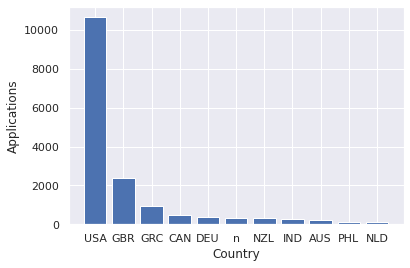

In [18]:
# as most no of postings were from US it was acting  as an outlier 
# hence we will plot the graph too 
# there are lot of countries with 1 or 2 applications so we'll plot the ones 
# with max applications 
plt.bar([x for x in range(11)],loc_list.value_counts()[:11])
plt.xlabel("Country")
plt.ylabel("Applications")
plt.xticks([x for x in range(11)],loc_list.value_counts().index[:11])
plt.plot()

In [19]:
df['department'].value_counts().head(20)

Sales                     551
Engineering               487
Marketing                 401
Operations                270
IT                        225
Development               146
Product                   112
Information Technology     86
Technology                 76
Design                     76
Customer Service           73
Finance                    69
HR                         56
tech                       55
R&D                        54
Creative                   48
Client Services            45
Retail                     45
Product Development        36
Oil and Gas                32
Name: department, dtype: int64

In [20]:
# df['department'].fillna('none',inplace=True)

[]

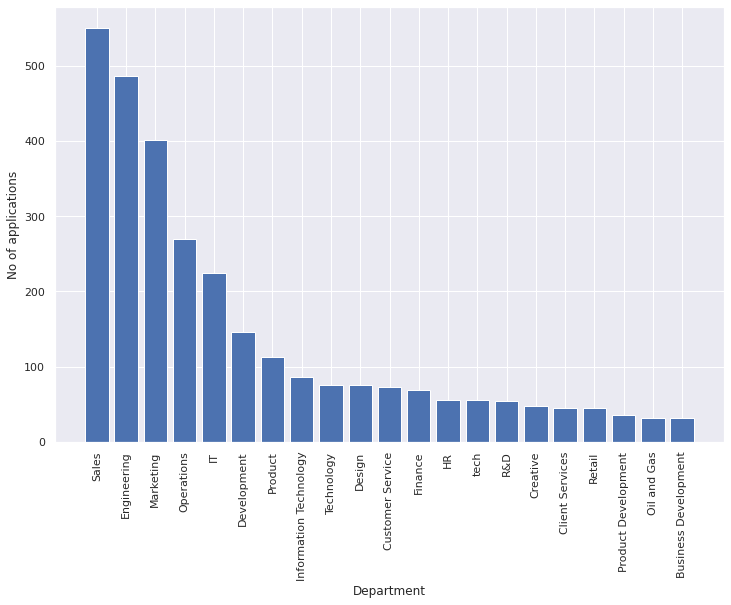

In [21]:
# top 20 Department options 
plt.figure(figsize=(12,8))
plt.bar([x for x in range(21)],df['department'].value_counts()[:21])
plt.xticks([x for x in range(21)],df['department'].value_counts().index[:21],rotation=90)
plt.xlabel('Department')
plt.ylabel('No of applications')
plt.plot()

In [25]:
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


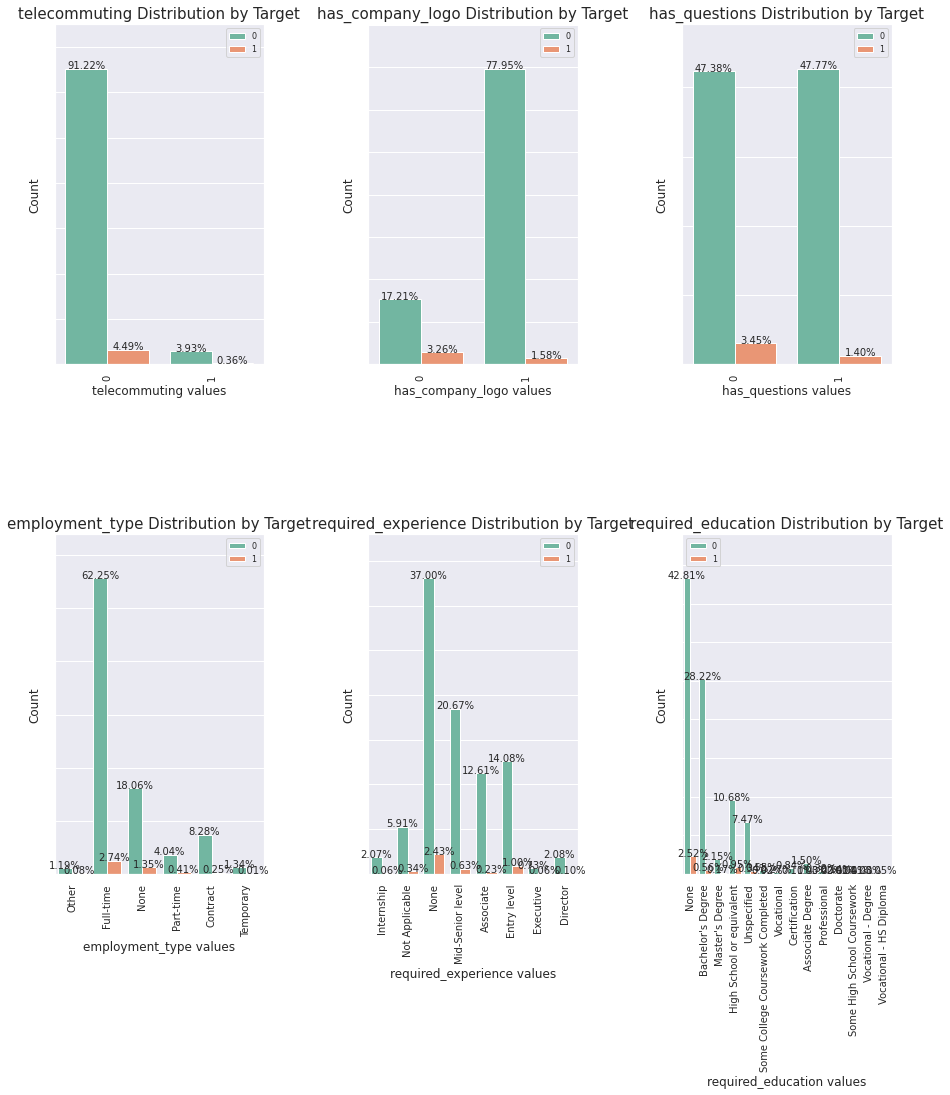

In [26]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()

In [66]:
df_cr = df.copy()

In [57]:
df_cr.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,location_count,null_count
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,USA,1,4
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZL,1,2
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,USA,1,8
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,USA,1,1
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,USA,1,2


In [67]:
df_cr['department'].fillna('none',inplace=True)

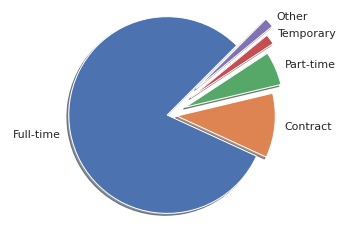

In [148]:
#plotting different employment types using pie chart 
labels = ['Full-time','Contract','Part-time','Temporary','Other']
sizes =[df['employment_type'].value_counts()[x] for x in range(5)]
explode = (0,0.1,0.2,0.3,0.4)

#plot
plt.pie(sizes,labels=labels,explode=explode,
       shadow=True,startangle=45)
plt.axis('equal')
plt.show()

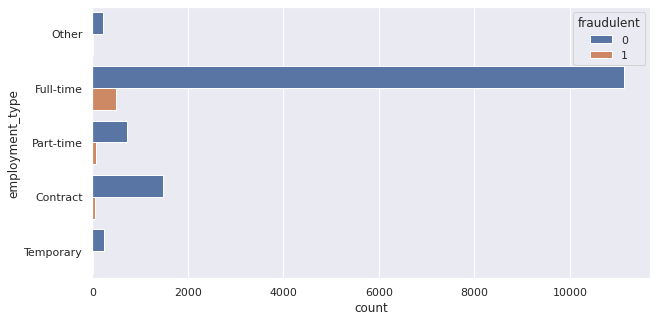

In [149]:
plt.figure(figsize=(10,5))
sns.countplot(y='employment_type',data=df,hue='fraudulent');

In [150]:
#Check if there is any relationship between the target class and employment_type
df.pivot_table(index=['fraudulent'], columns='employment_type', aggfunc='size', fill_value=0)


employment_type,Contract,Full-time,Other,Part-time,Temporary
fraudulent,,,,,
0,1480,11130,212,723,239
1,44,490,15,74,2


**Required_Education**

In [151]:
df['required_education'].astype('category').value_counts()

Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

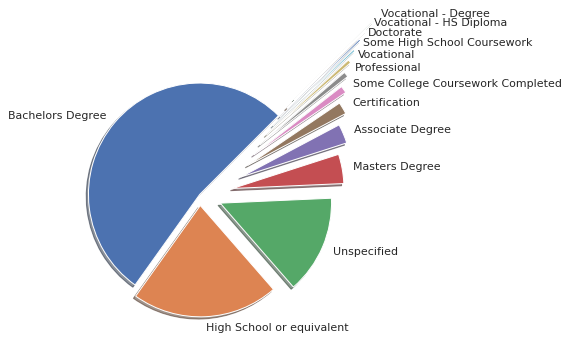

In [152]:
#plotting different employment types using pie chart 
labels = ['Bachelors Degree','High School or equivalent','Unspecified','Masters Degree','Associate Degree',
          'Certification','Some College Coursework Completed','Professional','Vocational',
          'Some High School Coursework','Doctorate','Vocational - HS Diploma','Vocational - Degree']
sizes =[df['required_education'].value_counts()[x] for x in range(13)]
explode = (0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2)

#plot
plt.figure(figsize=(8,6))
plt.pie(sizes,labels=labels,explode=explode,
       shadow=True,startangle=45)
plt.axis('equal')
plt.show()

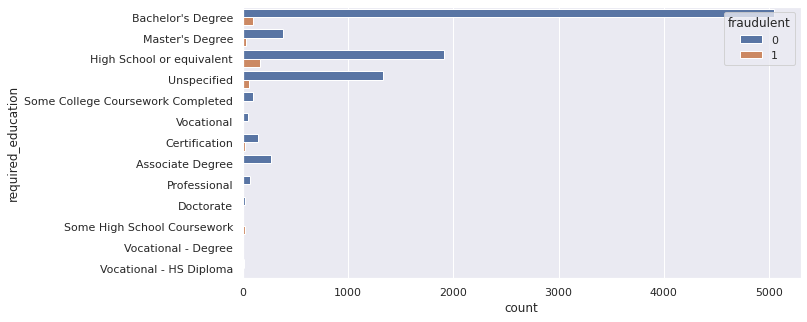

In [153]:
plt.figure(figsize=(10,5))
sns.countplot(y='required_education',data=df,hue='fraudulent');

In [154]:
#Check if there is any relationship between the target class and required_education
df.pivot_table(index=['fraudulent'], columns=['required_education'], aggfunc='size', fill_value=0)
#Clearly,required_educationrequired_experience,doesn't have any significant impact. SO we shall remove it

required_education,Associate Degree,Bachelor's Degree,Certification,Doctorate,High School or equivalent,Master's Degree,Professional,Some College Coursework Completed,Some High School Coursework,Unspecified,Vocational,Vocational - Degree,Vocational - HS Diploma
fraudulent,,,,,,,,,,,,,
0,268,5045,151,25,1910,385,70,99,7,1336,49,6,9
1,6,100,19,1,170,31,4,3,20,61,0,0,0


**Required_Experience**

In [155]:
df['required_experience'].astype('category').value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

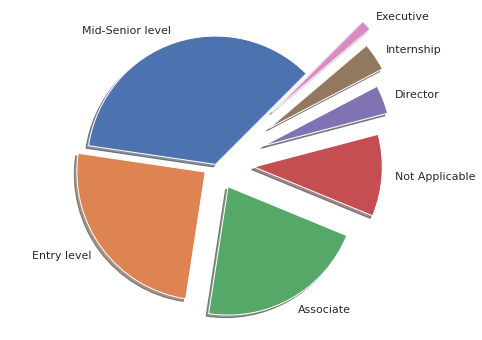

In [156]:
#plotting different required_experience using pie chart 
labels = ['Mid-Senior level','Entry level','Associate','Not Applicable','Director',
          'Internship','Executive']
sizes =[df['required_experience'].value_counts()[x] for x in range(7)]
explode = (0,0.1,0.2,0.3,0.4,0.5,0.6)

#plot
plt.figure(figsize=(8,6))
plt.pie(sizes,labels=labels,explode=explode,
       shadow=True,startangle=45)
plt.axis('equal')
plt.show()

In [157]:
#Check if there is any relationship between the target class and required_education
df.pivot_table(index=['fraudulent'], columns=['required_experience'], aggfunc='size', fill_value=0)
#Clearly,required_educationrequired_experience,doesn't have any significant impact. SO we shall remove it

required_experience,Associate,Director,Entry level,Executive,Internship,Mid-Senior level,Not Applicable
fraudulent,,,,,,,
0,2255,372,2518,131,371,3696,1056
1,42,17,179,10,10,113,60


In [158]:
df['department'].value_counts()[:20]

Sales                     551
Engineering               487
Marketing                 401
Operations                270
IT                        225
Development               146
Product                   112
Information Technology     86
Design                     76
Technology                 76
Customer Service           73
Finance                    69
HR                         56
tech                       55
R&D                        54
Creative                   48
Retail                     45
Client Services            45
Product Development        36
Oil and Gas                32
Name: department, dtype: int64

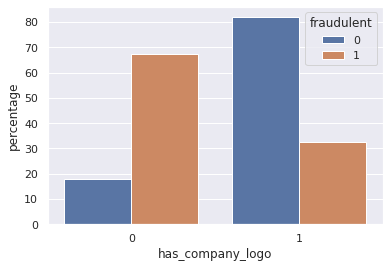

In [159]:
sns.barplot(x="has_company_logo", y="percentage", hue="fraudulent", data=df.groupby(['fraudulent'])['has_company_logo']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('has_company_logo'));

In [23]:
df.fillna(' ',inplace=True)

In [24]:
df['text']=df['title']+" " + df['department'] + " " + df['company_profile'] + " " + df['description'] + " " + df['requirements'] + " " + df['benefits'] + " " 

In [25]:
df['text_length']=df['text'].apply(lambda x:len(x.split()))

In [163]:
import plotly.express as px

px.histogram(data_frame=df,x="text_length",color='fraudulent',marginal='rug')

Text(0.5, 0, 'Text Length')

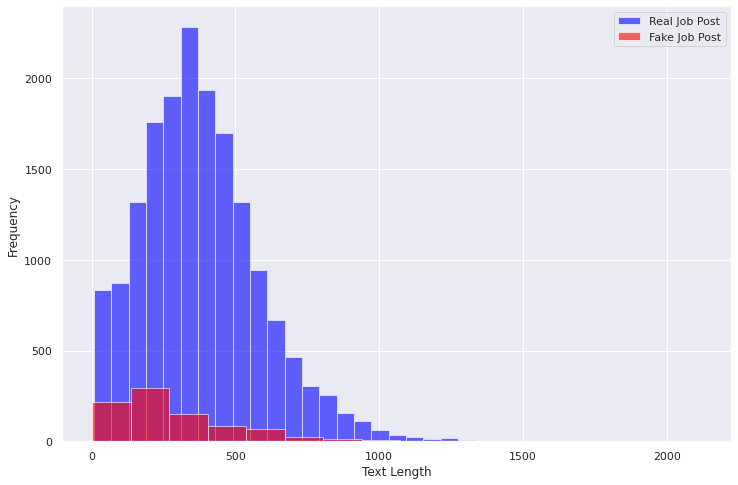

In [164]:
plt.figure(figsize=(12, 8))

df[df.fraudulent==0].text_length.plot(bins=35, kind='hist', color='blue', 
                                       label='Real Job Post', alpha=0.6)
df[df.fraudulent==1].text_length.plot(kind='hist', color='red', 
                                       label='Fake Job Post', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17880 non-null  object
 3   department           17880 non-null  object
 4   salary_range         17880 non-null  object
 5   company_profile      17880 non-null  object
 6   description          17880 non-null  object
 7   requirements         17880 non-null  object
 8   benefits             17880 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      17880 non-null  object
 13  required_experience  17880 non-null  object
 14  required_education   17880 non-null  object
 15  industry             17880 non-null  object
 16  func

In [27]:
#Delete all the un-necessary Columns
delete_list=['job_id','title','location','telecommuting','has_company_logo','has_questions','department','salary_range','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function']

for val in delete_list:
    del df[val]
df.head()

,fraudulent,country,location_count,null_count,text,text_length
0,0,USA,1,4,"Marketing Intern Marketing We're Food52, and w...",383
1,0,NZL,1,2,Customer Service - Cloud Video Production Succ...,902
2,0,USA,1,8,Commissioning Machinery Assistant (CMA) Valo...,359
3,0,USA,1,1,Account Executive - Washington DC Sales Our pa...,710
4,0,USA,1,2,Bill Review Manager SpotSource Solutions LLC...,470


In [28]:
df.drop(["country","location_count","null_count"],axis = 1, inplace=True)

In [29]:
df.head()

,fraudulent,text,text_length
0,0,"Marketing Intern Marketing We're Food52, and w...",383
1,0,Customer Service - Cloud Video Production Succ...,902
2,0,Commissioning Machinery Assistant (CMA) Valo...,359
3,0,Account Executive - Washington DC Sales Our pa...,710
4,0,Bill Review Manager SpotSource Solutions LLC...,470


In [30]:

df['text']=df['text'].str.replace('\n','')
df['text']=df['text'].str.replace('\r','')
df['text']=df['text'].str.replace('\t','')
  
  #This removes unwanted texts
df['text'] = df['text'].apply(lambda x: re.sub(r'[0-9]','',x))
df['text'] = df['text'].apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',x))
  
  #Converting all upper case to lower case
df['text']= df['text'].apply(lambda s:s.lower() if type(s) == str else s)
  

  #Remove un necessary white space
df['text']=df['text'].str.replace('  ',' ')


#removing html tags
p = re.compile(r'<.*?>')
df['text'] = df['text'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
df['text'] = df['text'].apply(lambda x: re.sub(r"\'ve", " have ", x))
df['text'] = df['text'].apply(lambda x: re.sub(r"can't", "cannot ", x))
df['text'] = df['text'].apply(lambda x: re.sub(r"n't", " not ", x))
df['text'] = df['text'].apply(lambda x: re.sub(r"I'm", "I am", x))
df['text'] = df['text'].apply(lambda x: re.sub(r" m ", " am ", x))
df['text'] = df['text'].apply(lambda x: re.sub(r"\'re", " are ", x))
df['text'] = df['text'].apply(lambda x: re.sub(r"\'d", " would ", x))
df['text'] = df['text'].apply(lambda x: re.sub(r"\'ll", " will ", x))
df['text'] = df['text'].apply(lambda x: p.sub('', x))




# text = re.sub(r"\'ve", " have ", text)
# text = re.sub(r"can't", "cannot ", text)
# text = re.sub(r"n't", " not ", text)
# text = re.sub(r"I'm", "I am", text)
# text = re.sub(r" m ", " am ", text)
# text = re.sub(r"\'re", " are ", text)
# text = re.sub(r"\'d", " would ", text)
# text = re.sub(r"\'ll", " will ", text)
# text = p.sub('', text)

  #Remove Stop words
nlp=spacy.load("en_core_web_sm")
df['text'] =df['text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))



In [31]:
df.head()

,fraudulent,text,text_length
0,0,marketing intern marketing food created ground...,383
1,0,customer service cloud video production succes...,902
2,0,commissioning machinery assistant cma valor se...,359
3,0,account executive washington dc sales passion ...,710
4,0,bill review manager spotsource solutions llc g...,470


In [ ]:
# before lemmanization

In [68]:
df_cr['employment_type'].fillna("none",inplace=True)

In [69]:
df_cr['required_experience'].fillna('Not Applicable',inplace=True)

In [70]:
df_cr['required_education'].fillna('Unspecified',inplace=True)

In [71]:
df_cr['industry'].fillna('not specified',inplace=True)

In [72]:
df_cr['function'].fillna('not specified',inplace=True)

In [73]:
df_cr['text']=df_cr[['title', 'company_profile', 'description','requirements','benefits']].fillna('').agg(' '.join, axis=1)

In [74]:
df_cr['text']=df_cr['text'].str.replace('\n','')
df_cr['text']=df_cr['text'].str.replace('\r','')
df_cr['text']=df_cr['text'].str.replace('\t','')
  
  #This removes unwanted texts
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r'[0-9]','',x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',x))
  
  #Converting all upper case to lower case
df_cr['text']= df_cr['text'].apply(lambda s:s.lower() if type(s) == str else s)
  

  #Remove un necessary white space
df_cr['text']=df_cr['text'].str.replace('  ',' ')


#removing html tags
p = re.compile(r'<.*?>')
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r"\'ve", " have ", x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r"can't", "cannot ", x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r"n't", " not ", x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r"I'm", "I am", x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r" m ", " am ", x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r"\'re", " are ", x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r"\'d", " would ", x))
df_cr['text'] = df_cr['text'].apply(lambda x: re.sub(r"\'ll", " will ", x))
df_cr['text'] = df_cr['text'].apply(lambda x: p.sub('', x))




# text = re.sub(r"\'ve", " have ", text)
# text = re.sub(r"can't", "cannot ", text)
# text = re.sub(r"n't", " not ", text)
# text = re.sub(r"I'm", "I am", text)
# text = re.sub(r" m ", " am ", text)
# text = re.sub(r"\'re", " are ", text)
# text = re.sub(r"\'d", " would ", text)
# text = re.sub(r"\'ll", " will ", text)
# text = p.sub('', text)

  #Remove Stop words
nlp=spacy.load("en_core_web_sm")
df_cr['text'] =df_cr['text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))

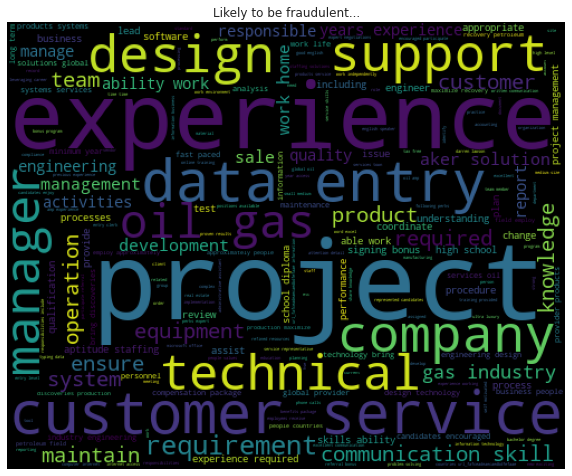

In [36]:
from wordcloud import WordCloud
x =df_cr[df_cr['fraudulent']==1]

# word cloud of the job description 
words = x['text'][~pd.isnull(x['text'])]
wordcloud = WordCloud(width=500,height=400).generate(''.join(words))

plt.figure(figsize=(10,12))
plt.axis('off')
plt.title('Likely to be fraudulent...')
plt.imshow(wordcloud)
plt.show()

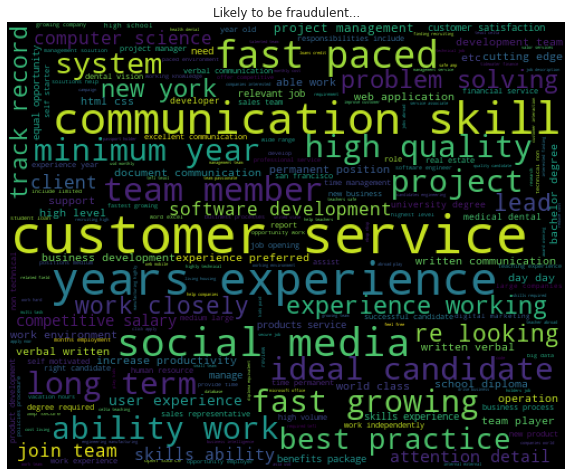

In [37]:
from wordcloud import WordCloud
x =df_cr[df_cr['fraudulent']==0]

# word cloud of the job description 
words = x['text'][~pd.isnull(x['text'])]
wordcloud = WordCloud(width=500,height=400).generate(''.join(words))

plt.figure(figsize=(10,12))
plt.axis('off')
plt.title('Likely to be fraudulent...')
plt.imshow(wordcloud)
plt.show()

In [75]:
df_cr['text_length']=df_cr['text'].apply(lambda x:len(x.split()))

In [206]:
px.histogram(data_frame=df_cr,x="text_length",color='fraudulent',marginal='rug')

In [76]:
df_cr['company_profile'].apply(lambda x:print(x) if 'see more' in str(x).lower() else False)

At LendInvest fundamentally changing the way people think about their savings, investments and how you get a mortgage. We're the new generation of finance, which is far less stuffy as we are building a new way to do things - and having some fun along the way. If you want to be part of building the future of finance, then we'd love to hear from you. LendInvest has been prominently recognised as a leader for its growth and innovation. We are based in a prime central London building, with a very cool work environment.LendInvest is a direct employer and we therefore do not work with any recruitment agencies. Recruiters, please do not spam us, we are not interested in hearing from you.For a look at what we're creating, you can see more on our site at: #URL_a472ef05be663cdc9df7eb234d26330394196f039430435745cd6695790fd82e#
The Amani Institute is about developing whole individuals who have the knowledge and practical skills required to solve today's problems and the networks to be equipped to 

0        False
1        False
2        False
3        False
4        False
         ...  
17875    False
17876    False
17877    False
17878    False
17879    False
Name: company_profile, Length: 17880, dtype: object

In [77]:
df_cr[df_cr['company_profile'].apply(lambda x:True if 'see more' in str(x).lower() else False)]['company_profile'].count()

46

In [ ]:
#Lemmenization
#Time module is just to measure the time it took as compared with Spacy, NLTK and Gensim. Spacy was the fastest
sp = spacy.load('en_core_web_sm')
import time
t1=time.time()
output=[]

for sentence in df['text']:
    sentence=sp(str(sentence))
    s=[token.lemma_ for token in sentence]
    output.append(' '.join(s))
df['processed']=pd.Series(output)
t=time.time()-t1
print("Time" + str(t))

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 0].processed))
plt.imshow(wc , interpolation = 'bilinear')

In [79]:
x_train,x_test,y_train,y_test=train_test_split(df_cr, df_cr['fraudulent'], test_size=0.2,stratify=df_cr['fraudulent'], random_state=42)

*** numerical data scaling***

In [80]:
numerical_features=['telecommuting','has_company_logo','has_questions','location_count','null_count','text_length']

scaler=StandardScaler()
num_train=csr_matrix(scaler.fit_transform(x_train[numerical_features]))
num_test=csr_matrix(scaler.transform(x_test[numerical_features]))

In [81]:
ohe=OneHotEncoder()
ohe_train=ohe.fit_transform(x_train[['required_education','employment_type','required_experience']])
ohe_test=ohe.transform(x_test[['required_education','employment_type','required_experience']])

*** Convert text into Count vectorize***

In [82]:
bow=CountVectorizer(ngram_range=(1,2))
text_train=bow.fit_transform(x_train['text'])
text_test=bow.transform(x_test['text'])

In [83]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

In [84]:
params={'C':[1,10,100,1000]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

1.0
0.8749999999999999
[[13611     0]
 [    0   693]]
[[3387   16]
 [  26  147]]


In [85]:
confusion_train = confusion_matrix(y_train,grid.predict(combined_train))
confusion_test = confusion_matrix(y_test,grid.predict(combined_test))


In [86]:
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(y_train,grid.predict(combined_train))
acc_test = accuracy_score(y_test,grid.predict(combined_test))
print(acc_train)
print(acc_test)

1.0
0.988255033557047


In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test,grid.predict(combined_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.90      0.85      0.87       173

    accuracy                           0.99      3576
   macro avg       0.95      0.92      0.93      3576
weighted avg       0.99      0.99      0.99      3576



***Convert text into tfidf vectorize***

In [88]:
tfidf=TfidfVectorizer(ngram_range=(1,2))
text_train=tfidf.fit_transform(x_train['text'])
text_test=tfidf.transform(x_test['text'])

In [89]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

In [90]:
params={'C':[1,10,100,1000]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

1.0
0.934131736526946
[[13611     0]
 [    0   693]]
[[3398    5]
 [  17  156]]


In [91]:
confusion_train = confusion_matrix(y_train,grid.predict(combined_train))
confusion_test = confusion_matrix(y_test,grid.predict(combined_test))

In [92]:
acc_train = accuracy_score(y_train,grid.predict(combined_train))
acc_test = accuracy_score(y_test,grid.predict(combined_test))
print(acc_train)
print(acc_test)

1.0
0.993847874720358


In [93]:
print(classification_report(y_test,grid.predict(combined_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       0.97      0.90      0.93       173

    accuracy                           0.99      3576
   macro avg       0.98      0.95      0.97      3576
weighted avg       0.99      0.99      0.99      3576



***Convert text into glove embedding***

In [94]:
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:27, 14513.95it/s]

Found 400000 word vectors.


In [95]:
# Function to generate TF-IDF weighted glove embedding
def glove_embedding(x):
    embed=[]
    tfidf_dict=tfidf.vocabulary_
    x=list(x.split())
    for word in x:
        try:
            embed.append(embeddings_index[word]*tfidf_dict[word])
        except:
            continue
    return np.mean(embed,axis=0)

In [96]:
text_train=x_train['text'].apply(glove_embedding)
text_test=x_test['text'].apply(glove_embedding)
text_train=text_train.apply(pd.Series)
text_test=text_test.apply(pd.Series)

In [97]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

In [98]:
params={'C':[0.01,0.1,1,10]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

0.41424802110817943
0.3686274509803921
[[11900  1711]
 [   65   628]]
[[2952  451]
 [  32  141]]


In [100]:
confusion_train = confusion_matrix(y_train,grid.predict(combined_train))
confusion_test = confusion_matrix(y_test,grid.predict(combined_test))
acc_train = accuracy_score(y_train,grid.predict(combined_train))
acc_test = accuracy_score(y_test,grid.predict(combined_test))
print(acc_train)
print(acc_test)

0.8758389261744967
0.8649328859060402


In [99]:
print(classification_report(y_test,grid.predict(combined_test)))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      3403
           1       0.24      0.82      0.37       173

    accuracy                           0.86      3576
   macro avg       0.61      0.84      0.65      3576
weighted avg       0.95      0.86      0.90      3576



In [101]:
clf=RandomForestClassifier(n_estimators=500,oob_score=True,n_jobs=-1,random_state=0)
clf.fit(text_train,y_train)
print(f1_score(y_train,clf.predict(text_train)))
print(f1_score(y_test,clf.predict(text_test)))
print(confusion_matrix(y_train,clf.predict(text_train)))
print(confusion_matrix(y_test,clf.predict(text_test)))

1.0
0.5462184873949579
[[13611     0]
 [    0   693]]
[[3403    0]
 [ 108   65]]


In [104]:
confusion_train = confusion_matrix(y_train,clf.predict(text_train))
confusion_test = confusion_matrix(y_test,clf.predict(text_test))
acc_train = accuracy_score(y_train,clf.predict(text_train))
acc_test = accuracy_score(y_test,clf.predict(text_test))
print(acc_train)
print(acc_test)

1.0
0.9697986577181208


In [106]:
print(classification_report(y_test,clf.predict(text_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3403
           1       1.00      0.38      0.55       173

    accuracy                           0.97      3576
   macro avg       0.98      0.69      0.77      3576
weighted avg       0.97      0.97      0.96      3576



***Bi-Directional LSTM***

In [107]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 100000
embedding_dim = 64
max_length = 250
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
#Tokenization

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_cr['text'].values)
word_index = tokenizer.word_index
print(len(word_index))

107563


In [108]:
X = tokenizer.texts_to_sequences(df_cr['text'].values)                         #Tokenize the dataset
X = pad_sequences(X, maxlen=max_length)     #Padding the dataset
Y=df_cr['fraudulent']                                                                   #Assign the value of y  
print(Y.shape)

(17880,)


In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20,random_state=41)

***Define Model***

In [110]:

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           6400000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 6,426,417
Trainable params: 6,426,417
Non-trainable params: 0
_________________________________________________________________


In [111]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train.shape

(14304, 250)

In [112]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
history = model.fit(X_train, y_train, epochs=10,batch_size=64, validation_split=0.1,callbacks=callbacks, verbose=1)

Epoch 1/10
202/202 [==============================] - 17s 57ms/step - loss: 0.1938 - accuracy: 0.9514 - val_loss: 0.1281 - val_accuracy: 0.9706
Epoch 2/10
202/202 [==============================] - 11s 54ms/step - loss: 0.0617 - accuracy: 0.9813 - val_loss: 0.0925 - val_accuracy: 0.9741
Epoch 3/10
202/202 [==============================] - 10s 50ms/step - loss: 0.0209 - accuracy: 0.9946 - val_loss: 0.1168 - val_accuracy: 0.9734
Epoch 4/10
202/202 [==============================] - 10s 51ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.1257 - val_accuracy: 0.9762


***EVALUATING BI-DIRECTIONAL LSTM***

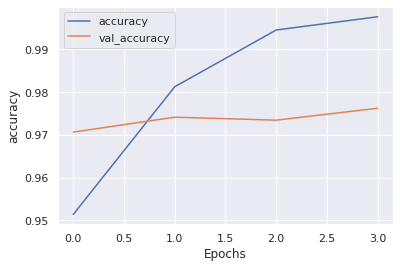

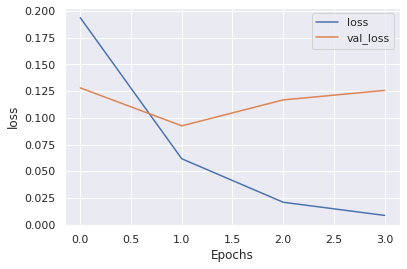

In [113]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [114]:
y_predict=model.predict(X_test)
y_predict = np.around(y_predict, decimals = 0)
y_predict

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [115]:
cf=confusion_matrix(y_test,y_predict)
cf

array([[3401,   13],
       [  64,   98]])

In [117]:
acc_bilSTM = accuracy_score(y_test,y_predict)
acc_bilSTM

0.9784675615212528

In [116]:
c_report=classification_report(y_test,y_predict,target_names = ['0','1'])
print(c_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3414
           1       0.88      0.60      0.72       162

    accuracy                           0.98      3576
   macro avg       0.93      0.80      0.85      3576
weighted avg       0.98      0.98      0.98      3576

